# Chapter 3 - A Tour of Machine Learning Classifers Using Scikit-Learn

The five main steps that are involved in training a supervised machine learning algorithm can be summarized as follows:

1. Selecting features and collecting labeled training examples;
2. Choosing a performance metric;
3. Choosing a classifer and optimization algorithm;
4. Evaluating the performance of the model;
5. Tuning the algorithm.

## 0 - First steps with scikit-learn

Import data:

In [1]:
from sklearn import datasets
import numpy as np

# Colunas do dataset: sepal_length, sepal_width, petal_length, petal_width, flower type (target).
# 0 - > Setosa.
# 1 - > Versicolor.
# 2 - > Virginica.
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

Plotting:

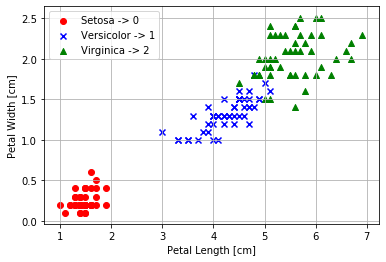

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot data.
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='Setosa -> 0')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='Versicolor -> 1')
plt.scatter(X[100:150, 0], X[100:150, 1],
            color='green', marker='^', label='Virginica -> 2')
plt.xlabel('Petal Length [cm]')
plt.ylabel('Petal Width [cm]')
plt.legend(loc='upper left')
plt.grid()
plt.show()

Splitting data into 70% training and 30% test data:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, random_state=1, stratify=y)

Standardizing the features:

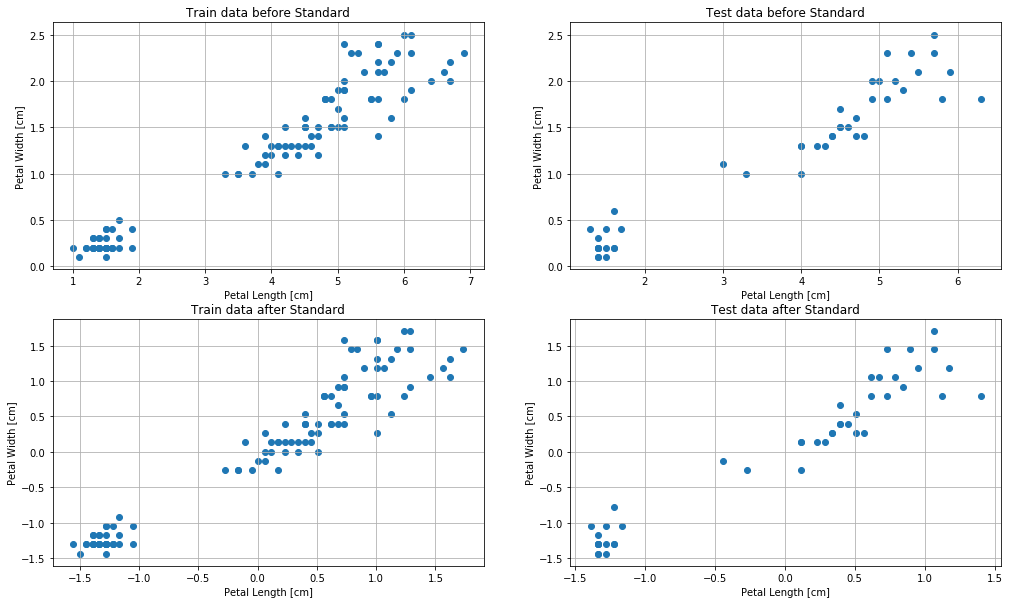

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)  # Estima média e desvio padrão para cada variável dos dados de treino.
X_train_std = sc.transform(X_train)  # Padronização dos dados de treino.
X_test_std = sc.transform(X_test)  # Padronização dos dados de teste.

from plot_std import plot_std
plot_std(X_train, X_test, X_train_std, X_test_std)

## 1 - Training a Perceptron via Scikit-Learn

### Train:

In [5]:
from sklearn.linear_model import Perceptron
percep = Perceptron(eta0=0.1, random_state=1, max_iter=100)
percep.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=100, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=1, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

### Test:

In [6]:
y_pred = percep.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())  # Soma das predições erradas.

Misclassified examples: 1


In [7]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.978


In [8]:
print('Accuracy: %.3f' % percep.score(X_test_std, y_test))

Accuracy: 0.978


# 2 - Plotting

In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # Setup marker generator and color map.
    markers = ('o', 'x', '^', '^', 'v')
    colors = ('red', 'blue', 'green', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot the decision surface.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.figure(figsize=(17,7))
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

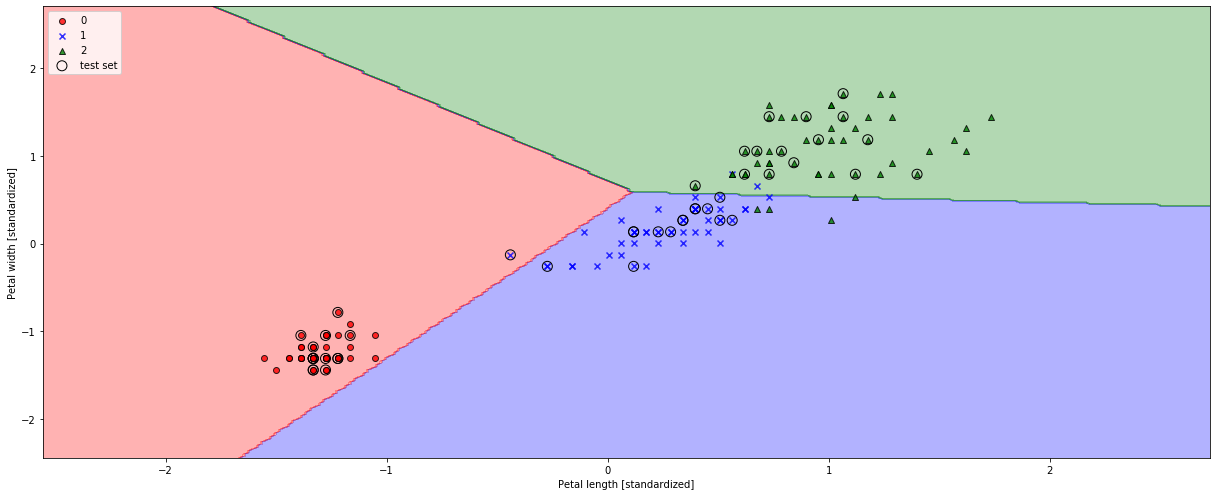

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=percep, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Modeling Class Probabilities via Logistic Regression

## 0 - Logistic regression intuition and conditional probabilities

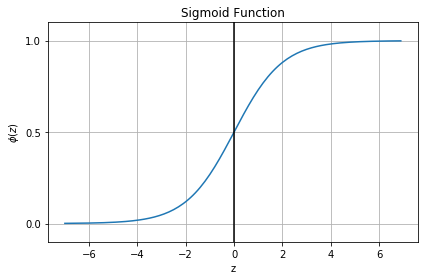

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
plt.title('Sigmoid Function')
plt.grid()

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

## 1 - Learning the weights of the logistic cost function

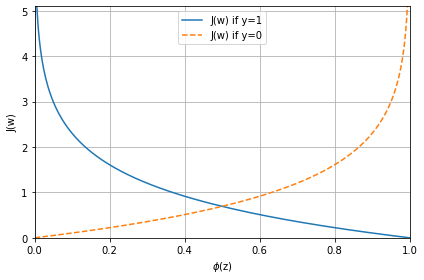

In [12]:
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.grid()
plt.show()

## 2 - Converting an Adaline implementation into an algorithm for logistic regression

In [13]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.
    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[0] += self.eta * errors.sum()
            self.w_[1:] += self.eta * X.T.dot(errors)
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

## 3 - Training

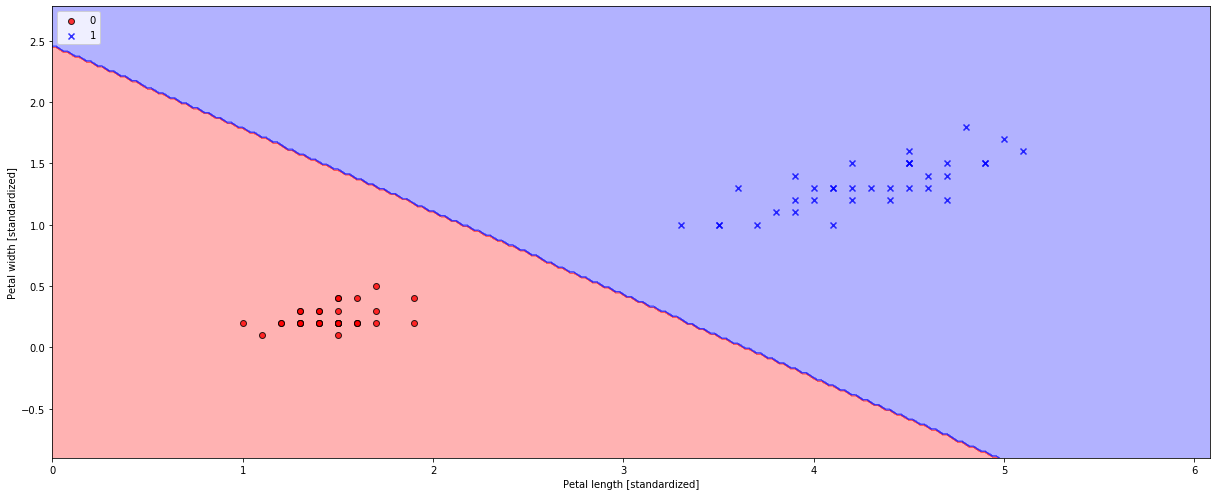

In [14]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 4 - Training a logistic regression model with scikit-learn

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=1,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

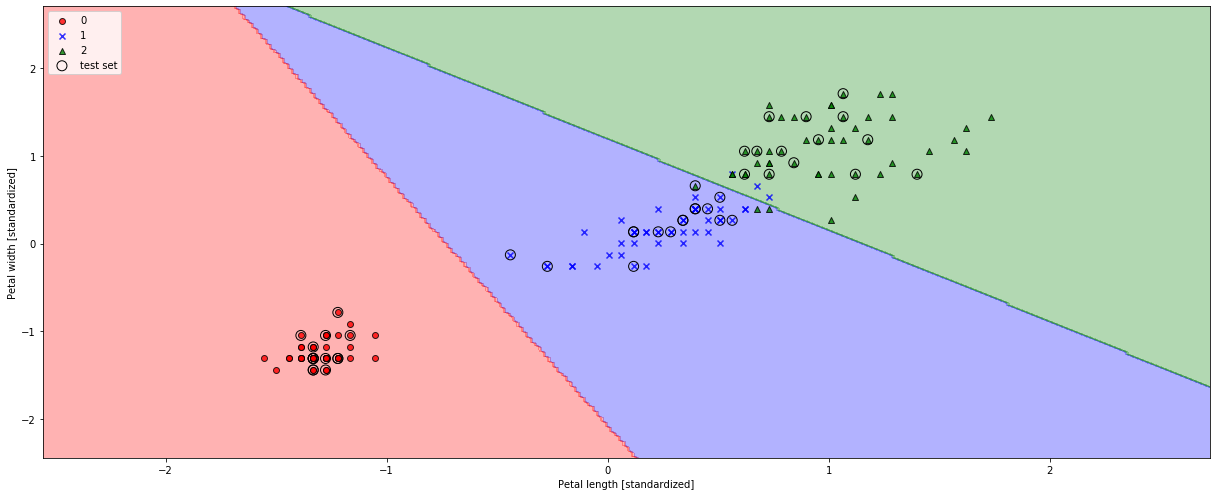

In [16]:
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 5 - Tackling overftting via regularization

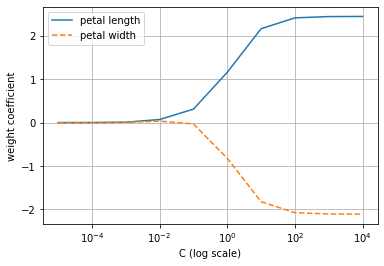

In [19]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1,
                            solver='lbfgs',
                            multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.grid()
plt.ylabel('weight coefficient')
plt.xlabel('C (log scale)')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

## Maximum margin classifcation with support vector machines

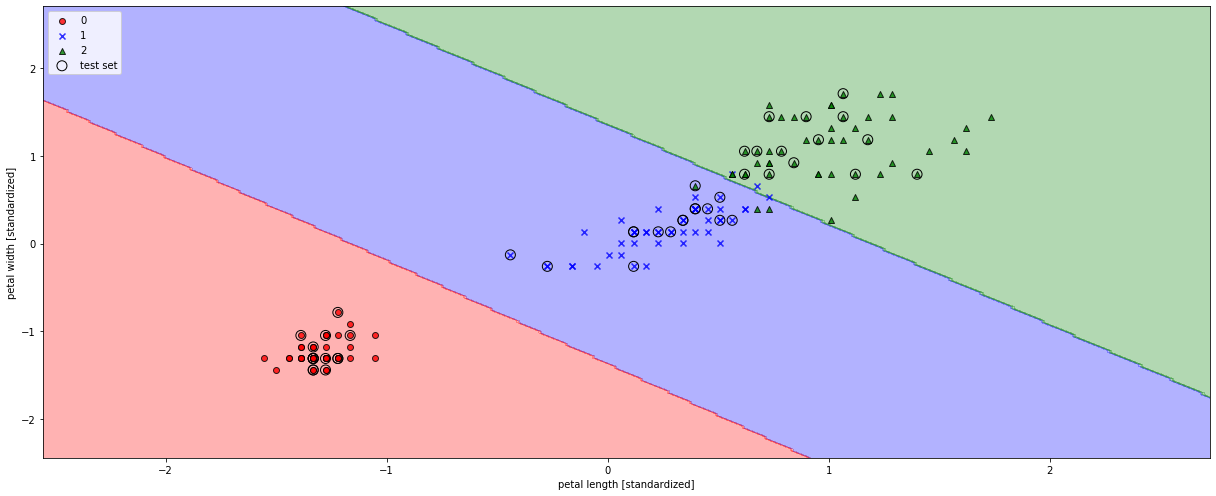

In [20]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()